In [73]:
# === Notebook Setup: Imports, Paths, Configuration ===

import sys
import os
import random
import pickle
from pathlib import Path
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

from typing import List, Tuple, Dict, Any, Optional

import nilearn.datasets

# --- Add src to sys.path ---
BASE_DIR = Path.cwd().parent
SRC_DIR = BASE_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))
    print(f"Added {SRC_DIR} to sys.path")
if str(BASE_DIR) not in sys.path:
     sys.path.insert(0, str(BASE_DIR))
     print(f"Added {BASE_DIR} to sys.path")

from file_utils import load_pickle
from network_utils import get_correlation_indices # Reusing this!
from modeling_utils import get_distances, find_optimal_clf_threshold
from stats_utils import permutation_test_accuracy, get_permutation_pvalue

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [78]:
# --- Configuration ---
# Define Paths relative to BASE_DIR
DATA_DIR = BASE_DIR / "data"
INTERIM_DATA_DIR = DATA_DIR / "interim"
MODELS_DIR = BASE_DIR / "models"
REPORTS_DIR = BASE_DIR / "reports"
FIGURE_DIR = REPORTS_DIR / "figures"
ANALYSIS_RESULTS_DIR = REPORTS_DIR / "analysis_results"
NETWORK_ANALYSIS_DIR = ANALYSIS_RESULTS_DIR / "network_analysis"
COMMUNITY_CLASSIFIER_DIR = ANALYSIS_RESULTS_DIR / "community_classifier" # New output dir

COMMUNITY_CLASSIFIER_DIR.mkdir(parents=True, exist_ok=True) # Create output dir

# --- Input Files ---
# 1. Processed FC data (containing fcs, labels, train/test masks)
FC_DATA_NPZ = INTERIM_DATA_DIR / "functional_connectivity_processed.npz" # From Notebook 1

# 2. Trained OVR Models (Dictionary of fitted OVR classifiers)
MULTICLASS_MODEL_PKL = MODELS_DIR / "threeclass_onevrest_classifier_weights.pkl" # Output from Notebook 1

# 3. Community Analysis Results (Pickle file containing comm_df DataFrames)
#    Need to load the specific file saved for each analysis group (e.g., OVR_L2_logistic_HC)
#    We'll construct the path dynamically later.

# --- Parameters ---
N_ROIS = 100 # Number of ROIs (must match data)
# List of the specific analysis keys (model_group) we want to evaluate communities for
# Make sure these keys match those used in Notebook 2 outputs (community_results, avg_dc_dfs)
# Example using OVR L2 Logistic for all 3 groups:
SELECTED_ANALYSIS_KEY = 'OVR_L2_logistic'
ANALYSIS_KEYS_TO_RUN = [
    'OVR_L2_logistic_HC',
    'OVR_L2_logistic_Cannabis',
    'OVR_L2_logistic_Alcohol'
]
# Define mapping from analysis key group suffix to class index in the OVR model
# This assumes OVR estimators are ordered [HC vs Rest, Cannabis vs Rest, Alcohol vs Rest]
GROUP_SUFFIX_TO_ESTIMATOR_INDEX = {'HC': 0, 'Cannabis': 1, 'Alcohol': 2}
MULTICLASS_LABELS = ['HC', 'Cannabis', 'Alcohol']

# Permutation Settings (set to 0 initially to skip)
N_PERMUTATIONS = 100 # Set > 0 to enable permutation testing

# Random seed for permutations if used
PERMUTATION_SEED = 456

In [18]:
# --- Load Processed FC Data and Combine ---

print(f"Loading processed FC data from: {FC_DATA_NPZ}")
fcs_list = []
labels_list = []
sub_names_list = []
training_list = [] # Uncomment if needed

try:
    with np.load(FC_DATA_NPZ) as infile:
        print(f"  Available keys in npz file: {list(infile.keys())}")

        # Load Alcohol Data (if present)
        if 'alcohol_fcs' in infile and infile['alcohol_fcs'].size > 0:
            print(f"  Loading Alcohol data (shape: {infile['alcohol_fcs'].shape})")
            fcs_list.append(infile['alcohol_fcs'])
            labels_list.append(infile['alcohol_labels'])
            sub_names_list.append(infile['alcohol_sub_names'])
            # if 'alcohol_run_ids' in infile: run_ids_list.append(infile['alcohol_run_ids'])
            if 'alcohol_training' in infile: training_list.append(infile['alcohol_training'])
        else:
            print("  Alcohol data not found or empty in npz file.")

        # Load Cannabis Data (if present)
        if 'cannabis_fcs' in infile and infile['cannabis_fcs'].size > 0:
            print(f"  Loading Cannabis data (shape: {infile['cannabis_fcs'].shape})")
            fcs_list.append(infile['cannabis_fcs'])
            labels_list.append(infile['cannabis_labels'])
            sub_names_list.append(infile['cannabis_sub_names'])
            # if 'cannabis_run_ids' in infile: run_ids_list.append(infile['cannabis_run_ids'])
            if 'cannabis_training' in infile: training_list.append(infile['cannabis_training'])
        else:
            print("  Cannabis data not found or empty in npz file.")

        # Check if any data was loaded
        if not fcs_list:
            raise ValueError("No valid FC data loaded from the npz file.")

        # Concatenate the loaded data
        fcs = np.concatenate(fcs_list, axis=0)
        labels = np.concatenate(labels_list, axis=0)
        sub_names = np.concatenate(sub_names_list, axis=0)
        # run_ids = np.concatenate(run_ids_list, axis=0)
        training_mask = np.concatenate(training_list, axis=0).astype(bool)
        testing_mask = ~training_mask

        print("\nConcatenated Data Shapes:")
        print(f"  fcs: {fcs.shape}")
        print(f"  labels: {labels.shape}")
        print(f"  sub_names: {sub_names.shape}")
        # print(f"  run_ids: {run_ids.shape}")
        print(f"  Training samples: {np.sum(training_mask)}, Testing samples: {np.sum(testing_mask)}")

except FileNotFoundError:
    raise FileNotFoundError(f"Input FC data file not found at {FC_DATA_NPZ}. Ensure notebook 1 saved it correctly.")
except Exception as e:
    raise RuntimeError(f"Failed to load or process {FC_DATA_NPZ}: {e}")


# --- Load Models ---
print(f"\nLoading models from {MULTICLASS_MODEL_PKL}")
try:
    # This loads the dictionary of models saved by MultiClassEvaluator
    # Keys are like 'OVR_L1_logistic', 'OVO_L2_LinearSVC', etc.
    all_fitted_models = load_pickle(MULTICLASS_MODEL_PKL) # Using function from src/file_utils
    print(f"  Loaded models for keys: {list(all_fitted_models.keys())}")
except Exception as e:
    raise RuntimeError(f"Failed to load models from {MULTICLASS_MODEL_PKL}: {e}")

print("\nModel loading complete. Weight extraction will occur during WFC calculation.")

2025-04-21 12:17:51,150 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/threeclass_onevrest_classifier_weights.pkl


Loading processed FC data from: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/interim/functional_connectivity_processed.npz
  Available keys in npz file: ['alcohol_fcs', 'alcohol_labels', 'alcohol_sub_names', 'alcohol_training', 'cannabis_fcs', 'cannabis_labels', 'cannabis_sub_names', 'cannabis_training']
  Loading Alcohol data (shape: (320, 4950))
  Loading Cannabis data (shape: (411, 4950))

Concatenated Data Shapes:
  fcs: (731, 4950)
  labels: (731,)
  sub_names: (731,)
  Training samples: 579, Testing samples: 152

Loading models from /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/threeclass_onevrest_classifier_weights.pkl
  Loaded models for keys: ['OVR_L1_logistic', 'OVR_L2_logistic', 'OVR_L1_LinearSVC', 'OVR_L2_LinearSVC']

Model loading complete. Weight extraction will occur during WFC calculation.


In [44]:
# === Helper Functions ===

def get_classifier_params(model_key: str, group_suffix: str, all_models_dict: dict) -> Tuple[Optional[np.ndarray], Optional[float]]:
    """Extracts weights and intercept for the relevant estimator within an OVR/OVO model."""
    if model_key not in all_models_dict:
        logging.error(f"Model key '{model_key}' not found in dictionary.")
        return None, None

    multiclass_wrapper = all_models_dict[model_key]

    # Determine which estimator index corresponds to the group suffix
    estimator_index = GROUP_SUFFIX_TO_ESTIMATOR_INDEX.get(group_suffix)
    if estimator_index is None:
        logging.error(f"Could not determine estimator index for group suffix '{group_suffix}'. Check GROUP_SUFFIX_TO_ESTIMATOR_INDEX mapping.")
        return None, None

    # Access the specific estimator
    base_estimator = None
    if hasattr(multiclass_wrapper, 'estimators_') and len(multiclass_wrapper.estimators_) > estimator_index:
         base_estimator = multiclass_wrapper.estimators_[estimator_index]
    elif hasattr(multiclass_wrapper, 'estimator') and estimator_index == 0: # Handle case where OVR/OVO might have single 'estimator' if base doesn't support multiclass natively? Unlikely for SGD.
         base_estimator = multiclass_wrapper.estimator
    else:
        logging.error(f"Could not access estimator at index {estimator_index} for model '{model_key}'.")
        return None, None

    # Extract weights and intercept
    weights = None
    intercept = None
    if hasattr(base_estimator, 'coef_') and base_estimator.coef_.ndim == 2:
        weights = base_estimator.coef_[0] # Assuming shape (1, n_features)
    elif hasattr(base_estimator, 'coef_'): # Handle potential 1D coef_ array
        weights = base_estimator.coef_
    else:
        logging.error(f"Base estimator for '{model_key}' (index {estimator_index}) has no 'coef_'.")

    if hasattr(base_estimator, 'intercept_'):
        intercept = float(base_estimator.intercept_[0]) # Assuming shape (1,)
    else:
        logging.error(f"Base estimator for '{model_key}' (index {estimator_index}) has no 'intercept_'.")

    if weights is None or intercept is None:
        return None, None # Return None if extraction failed

    return weights, intercept


def calculate_subset_decision_values(
    fcs_data: np.ndarray,      # Shape (n_runs, n_total_features)
    feature_indices: np.ndarray,# Indices of features to use
    weights: np.ndarray,       # Full weight vector (n_total_features,)
    intercept: float
) -> np.ndarray:
    """Calculates decision function value using only a subset of features and weights."""
    if feature_indices.size == 0: # Handle case with no features selected
         return np.full(fcs_data.shape[0], intercept) # Return only intercept

    if np.max(feature_indices) >= fcs_data.shape[1] or np.max(feature_indices) >= len(weights):
         raise IndexError("Feature indices are out of bounds for fcs data or weights.")

    # Subset features and weights
    fcs_subset = fcs_data[:, feature_indices]
    weights_subset = weights[feature_indices]

    # Calculate distances using only the subset
    return get_distances(fcs_subset, weights_subset, intercept) # Use function from modeling_utils


print("Helper functions defined.")

Helper functions defined.


In [31]:
# Load parcel names separately from Atlas (more robust)
schaefer_atlas = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=N_ROIS)
raw_labels = schaefer_atlas['labels'].astype(str)
parcel_names = ['_'.join(label.split('_')[1:]) for label in raw_labels]
print(f"Loaded {len(parcel_names)} parcel names from Nilearn.")

Loaded 100 parcel names from Nilearn.


In [51]:
# === 2b. Prepare 3-Way Classification Data ===
# This cell combines the loaded alcohol and cannabis data (and potentially controls
# inferred from the labels) into single train/test sets suitable for 3-way classification.
# It mirrors the logic from the original Cell 38 in 1_decoding.ipynb.

print("\n" + "="*40)
print("Starting 3-Way Classification Data Preparation")
print("="*40 + "\n")

# --- Define Class Labels ---
# Get integer labels from MULTICLASS_LABELS order, assuming HC is first (index 0)
CANNABIS_LABEL_INT = MULTICLASS_LABELS.index('Cannabis') if 'Cannabis' in MULTICLASS_LABELS else 1
ALCOHOL_LABEL_INT = MULTICLASS_LABELS.index('Alcohol') if 'Alcohol' in MULTICLASS_LABELS else 2 # Use config var as fallback

print(f"Using Integer Labels: HC=0, Cannabis={CANNABIS_LABEL_INT}, Alcohol={ALCOHOL_LABEL_INT}")

# --- Identify Group Data ---
# We need to identify which runs belong to which original group (Alc/Can)
# and their original label (0=Control, 1=User) to assign the correct 3-way label.
# Option 1: Load group-specific data from the NPZ file again.
# Option 2: Reconstruct group membership based on subject IDs if naming convention allows.
# Option 3: Assume 'labels' array ALREADY CONTAINS 0, 1, 2 appropriately (less likely).

# Let's implement Option 1 as it's the most robust, assuming the NPZ has the group data.
print(f"Reloading group-specific data from {FC_DATA_NPZ} to assign 3-way labels...")
try:
    with np.load(FC_DATA_NPZ) as infile:
        # Load alcohol data (features not needed again, just labels/training flags/subs)
        if 'alcohol_labels' in infile and infile['alcohol_labels'].size > 0:
            alc_labels_orig = infile['alcohol_labels'] # Original 0/1 labels
            alc_sub_names_orig = infile['alcohol_sub_names']
            alc_training_flags_orig = infile['alcohol_training'].astype(bool) # Boolean mask
            n_alc_runs = len(alc_labels_orig)
            print(f"  Loaded Alcohol meta-data ({n_alc_runs} runs).")
        else:
            raise ValueError("Alcohol data not found in NPZ file.")

        # Load cannabis data
        if 'cannabis_labels' in infile and infile['cannabis_labels'].size > 0:
            can_labels_orig = infile['cannabis_labels'] # Original 0/1 labels
            can_sub_names_orig = infile['cannabis_sub_names']
            can_training_flags_orig = infile['cannabis_training'].astype(bool) # Boolean mask
            n_can_runs = len(can_labels_orig)
            print(f"  Loaded Cannabis meta-data ({n_can_runs} runs).")
        else:
            raise ValueError("Cannabis data not found in NPZ file.")

        # Verify total runs match the combined 'fcs' array loaded earlier
        if (n_alc_runs + n_can_runs) != fcs.shape[0]:
             logging.warning(f"Total runs from group data ({n_alc_runs + n_can_runs}) doesn't match loaded 'fcs' shape ({fcs.shape[0]}). Label assignment might be incorrect.")
             # Decide how to proceed - error out or attempt based on current fcs/labels?
             # Let's try to proceed using the loaded combined `fcs` and the group label info,
             # but this relies heavily on the concatenation order being Alc then Can.

        # --- Assign 3-Way Labels ---
        # Create the target three_y array based on original group and label
        # Assumes original 0 = Control (HC), 1 = User (Alc/Can)
        # Assumes the combined 'labels' array reflects the original 0/1 label for each run
        three_y = np.zeros_like(labels, dtype=int) # Start with all as HC (0)
        # Identify Alcohol runs in the combined data (ASSUMES Alc came first)
        is_alcohol_run = np.concatenate([np.ones(n_alc_runs, dtype=bool), np.zeros(n_can_runs, dtype=bool)])
        # Identify Cannabis runs in the combined data (ASSUMES Can came second)
        is_cannabis_run = np.concatenate([np.zeros(n_alc_runs, dtype=bool), np.ones(n_can_runs, dtype=bool)])

        # Assign Alcohol label (ALCOHOL_LABEL_INT) to runs that are Alcohol AND were originally labeled 1 (User)
        three_y[(is_alcohol_run) & (labels == 1)] = ALCOHOL_LABEL_INT
        # Assign Cannabis label (CANNABIS_LABEL_INT) to runs that are Cannabis AND were originally labeled 1 (User)
        three_y[(is_cannabis_run) & (labels == 1)] = CANNABIS_LABEL_INT
        # Runs that were originally label 0 remain as 0 (HC)

        # Verify label distribution
        unique_3way_labels, counts_3way = np.unique(three_y, return_counts=True)
        print("\nAssigned 3-Way Labels (Combined Data):")
        label_dist_str = ", ".join([f"{MULTICLASS_LABELS[lbl]} ({lbl}): {cnt}" for lbl, cnt in zip(unique_3way_labels, counts_3way)])
        print(f"  Distribution: {label_dist_str}")
        if len(unique_3way_labels) < 3:
            logging.warning("Fewer than 3 classes present in the combined 3-way labels.")


        # --- Split into Train/Test using the combined masks ---
        # Use the training_mask and testing_mask derived from the combined data loading step
        three_X_train = fcs[training_mask]
        three_y_train = three_y[training_mask]
        three_X_test = fcs[testing_mask]
        three_y_test = three_y[testing_mask]

        # --- Verification ---
        print("\nCreated 3-Way Train/Test Sets (Unscaled):")
        print(f"  Train: X={three_X_train.shape}, y={three_y_train.shape}")
        print(f"  Test:  X={three_X_test.shape}, y={three_y_test.shape}")

        unique_train, counts_train = np.unique(three_y_train, return_counts=True)
        unique_test, counts_test = np.unique(three_y_test, return_counts=True)
        print(f"  Train Label Distribution: {dict(zip(unique_train, counts_train))}")
        print(f"  Test Label Distribution: {dict(zip(unique_test, counts_test))}")


except FileNotFoundError:
    raise FileNotFoundError(f"Input FC data file not found at {FC_DATA_NPZ}.")
except KeyError as e:
     raise KeyError(f"Missing expected key '{e}' in {FC_DATA_NPZ}. Check saving logic in Notebook 1.")
except Exception as e:
    raise RuntimeError(f"Failed during 3-way data preparation: {e}")


print("\n" + "="*40)
print("Finished 3-Way Classification Data Preparation")
print("="*40 + "\n")


Starting 3-Way Classification Data Preparation

Using Integer Labels: HC=0, Cannabis=1, Alcohol=2
Reloading group-specific data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/interim/functional_connectivity_processed.npz to assign 3-way labels...
  Loaded Alcohol meta-data (320 runs).
  Loaded Cannabis meta-data (411 runs).

Assigned 3-Way Labels (Combined Data):
  Distribution: HC (0): 312, Cannabis (1): 259, Alcohol (2): 160

Created 3-Way Train/Test Sets (Unscaled):
  Train: X=(579, 4950), y=(579,)
  Test:  X=(152, 4950), y=(152,)
  Train Label Distribution: {0: 246, 1: 205, 2: 128}
  Test Label Distribution: {0: 66, 1: 54, 2: 32}

Finished 3-Way Classification Data Preparation



In [79]:
# === 3. Iterative Community-Based 3-Way Classification (Approximate + Permutations) ===
# This cell evaluates 3-way classification performance by iteratively adding
# communities (sorted by DC) and using only the features associated with those
# communities. It approximates this by zeroing out non-selected features
# and predicting with the original full classifier.
# Includes permutation testing for accuracy at each step.

print("\n" + "="*40)
print("Starting Iterative Community 3-Way Classification (Approximate + Permutations)")
print("="*40 + "\n")


# --- Store results ---
all_community_results_3way = {} # Key: group_analysis_key, Value: DataFrame

# --- Determine unique base models to analyze ---
base_models_to_analyze = sorted(list(set(['_'.join(key.split('_')[:-1]) for key in ANALYSIS_KEYS_TO_RUN])))
print(f"Base model strategies to analyze: {base_models_to_analyze}")

# --- Loop over base models ---
for base_model_key in base_models_to_analyze:
    print(f"\n--- Processing Base Model Strategy: {base_model_key} ---")

    # --- Loop over groups to get community rankings ---
    for group_suffix in ['HC', 'Cannabis', 'Alcohol']:
        group_analysis_key = f"{base_model_key}_{group_suffix}"
        print(f"\n  --- Using Community Ranking from: {group_analysis_key} ---")

        # --- Load the corresponding sorted community DataFrame ---
        comm_df_pickle_path = NETWORK_ANALYSIS_DIR / f"{group_analysis_key}_communities_df.pkl"
        try:
            comm_df = load_pickle(comm_df_pickle_path)
            if not isinstance(comm_df, pd.DataFrame) or comm_df.empty:
                 logging.error(f"    Loaded community data for '{group_analysis_key}' is empty or not a DataFrame. Skipping this ranking.")
                 continue # Skip to next group ranking
            comm_df = comm_df.sort_values(by='Mean DC', ascending=False, na_position='last').reset_index(drop=True)
            print(f"    Loaded sorted community DataFrame based on {group_analysis_key} ({len(comm_df)} communities).")
        except FileNotFoundError:
            logging.warning(f"    Community DataFrame pickle not found: {comm_df_pickle_path}. Skipping this ranking.")
            continue # Skip to next group ranking
        except Exception as e:
            logging.error(f"    Error loading community DataFrame for {group_analysis_key}: {e}. Skipping this ranking.")
            continue # Skip to next group ranking


        # --- Get the corresponding FULL 3-way classifier ---
        # Use the actual base_model_key for consistency
        full_classifier_object = all_fitted_models.get(base_model_key) # Try base key first
        if full_classifier_object is None:
             # Fallback: try the specific group key if base key fails
             full_classifier_object = all_fitted_models.get(group_analysis_key)
             if full_classifier_object is None:
                  logging.error(f"    Could not find fitted model for '{base_model_key}' or '{group_analysis_key}'. Skipping this ranking.")
                  continue


        # --- Loop through communities, adding one at a time ---
        results_list = []
        cumulative_parcel_indices = set()

        print(f"    Iterating through {len(comm_df)} communities...")
        for i, row in comm_df.iterrows():
            community_id = row['Community ID']
            current_community_indices = set(row['Parcel Indices'])
            cumulative_parcel_indices.update(current_community_indices)
            n_regions_cumulative = len(cumulative_parcel_indices)

            # Get flattened feature indices
            try:
                cumulative_feature_indices = get_correlation_indices(np.array(list(cumulative_parcel_indices)), N_ROIS)
                n_features_cumulative = len(cumulative_feature_indices)
                feature_mask = np.zeros(fcs.shape[1], dtype=bool)
                if n_features_cumulative > 0:
                    feature_mask[cumulative_feature_indices] = True
            except Exception as e:
                 logging.error(f"      Error getting feature indices for community {community_id}: {e}. Stopping iteration for this ranking.")
                 break


            # --- Create Modified Data ---
            X_train_modified = three_X_train.copy()
            X_test_modified = three_X_test.copy()
            X_train_modified[:, ~feature_mask] = 0
            X_test_modified[:, ~feature_mask] = 0

            # --- Predict using original classifier on MODIFIED data ---
            try:
                test_preds_3way_obs = full_classifier_object.predict(X_test_modified)
                train_preds_3way_obs = full_classifier_object.predict(X_train_modified)
            except Exception as e:
                logging.error(f"      Error predicting for community rank {i+1} (ID {community_id}): {e}. Stopping iteration for this ranking.")
                break

            # --- Calculate Observed 3-way Accuracy ---
            # Using try-except for safety, though predict should have worked if we got here
            try:
                 train_acc_3way_obs = accuracy_score(three_y_train, train_preds_3way_obs)
                 # Pass observed test predictions to permutation function
                 # test_acc_3way_obs is calculated within permutation_test_accuracy
            except Exception as e:
                 logging.error(f"      Error calculating observed accuracy for community rank {i+1} (ID {community_id}): {e}. Using NaN.")
                 train_acc_3way_obs = np.nan
                 test_preds_3way_obs = None # Ensure prediction isn't used if accuracy failed

            # --- Perform Permutation Test on Test Set ---
            perm_accs = np.array([]) # Initialize empty
            p_value = np.nan       # Initialize default

            # Only run if N_PERMUTATIONS > 0 and we have observed predictions
            if N_PERMUTATIONS > 0 and test_preds_3way_obs is not None:
                print(f"      Running {N_PERMUTATIONS} permutations for community rank {i+1}...")
                try:
                     # We need a stable prediction function. Using the fitted model's predict method.
                     # Note: predict_function itself doesn't change, only the shuffled labels used for scoring change.
                     _, perm_accs, p_value = permutation_test_accuracy(
                         y_true=three_y_test,
                         y_pred_observed=test_preds_3way_obs, # Use the observed predictions
                         predict_function=full_classifier_object.predict, # Pass the predict method
                         X_test_modified=X_test_modified, # Pass the modified X data (used by predict_function)
                         n_permutations=N_PERMUTATIONS,
                         random_state=PERMUTATION_SEED + i # Vary seed slightly per iteration
                     )
                except Exception as perm_e:
                     logging.error(f"        Permutation test failed: {perm_e}", exc_info=True)
                     # Keep p_value as NaN

            # Recalculate observed test accuracy outside permutation function for clarity
            test_acc_3way_obs = accuracy_score(three_y_test, test_preds_3way_obs) if test_preds_3way_obs is not None else np.nan

            # --- Store Results (including permutation p-value) ---
            results_list.append({
                'Base Model': base_model_key,
                'Community Ranking Source': group_suffix,
                'Num Communities': i + 1,
                'Last Community ID Added': community_id,
                'Cumulative Regions': n_regions_cumulative,
                'Cumulative Features': n_features_cumulative,
                'Train Accuracy (3-Way)': train_acc_3way_obs,
                'Test Accuracy (3-Way)': test_acc_3way_obs,
                'Permutation P-Value (Test Acc)': p_value, # Store the p-value
                # Optional: store perm_accs distribution if needed for later analysis
                # 'Permuted Accuracies': perm_accs
            })


        # --- Finalize results for this group's ranking ---
        if results_list:
            results_df = pd.DataFrame(results_list)
            # Store results using the group_analysis_key (identifies ranking source)
            all_community_results_3way[group_analysis_key] = results_df
            print(f"    Finished iterating {len(comm_df)} communities using {group_analysis_key} ranking.")
        else:
            print(f"    No results generated using {group_analysis_key} ranking.")


print("\n" + "="*40)
print("Finished Iterative Community 3-Way Classification Loop (Approximate + Permutations)")
print("="*40 + "\n")

2025-04-21 13:06:53,631 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_HC_communities_df.pkl



Starting Iterative Community 3-Way Classification (Approximate + Permutations)

Base model strategies to analyze: ['OVR_L2_logistic']

--- Processing Base Model Strategy: OVR_L2_logistic ---

  --- Using Community Ranking from: OVR_L2_logistic_HC ---
    Loaded sorted community DataFrame based on OVR_L2_logistic_HC (32 communities).
    Iterating through 32 communities...
      Running 100 permutations for community rank 1...
      Running 100 permutations for community rank 2...
      Running 100 permutations for community rank 3...
      Running 100 permutations for community rank 4...
      Running 100 permutations for community rank 5...
      Running 100 permutations for community rank 6...
      Running 100 permutations for community rank 7...
      Running 100 permutations for community rank 8...
      Running 100 permutations for community rank 9...
      Running 100 permutations for community rank 10...
      Running 100 permutations for community rank 11...
      Running 100

2025-04-21 13:06:54,031 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Cannabis_communities_df.pkl


      Running 100 permutations for community rank 16...
      Running 100 permutations for community rank 17...
      Running 100 permutations for community rank 18...
      Running 100 permutations for community rank 19...
      Running 100 permutations for community rank 20...
      Running 100 permutations for community rank 21...
      Running 100 permutations for community rank 22...
      Running 100 permutations for community rank 23...
      Running 100 permutations for community rank 24...
      Running 100 permutations for community rank 25...
      Running 100 permutations for community rank 26...
      Running 100 permutations for community rank 27...
      Running 100 permutations for community rank 28...
      Running 100 permutations for community rank 29...
      Running 100 permutations for community rank 30...
      Running 100 permutations for community rank 31...
      Running 100 permutations for community rank 32...
    Finished iterating 32 communities using OVR_

2025-04-21 13:06:54,489 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Alcohol_communities_df.pkl


      Running 100 permutations for community rank 35...
      Running 100 permutations for community rank 36...
    Finished iterating 36 communities using OVR_L2_logistic_Cannabis ranking.

  --- Using Community Ranking from: OVR_L2_logistic_Alcohol ---
    Loaded sorted community DataFrame based on OVR_L2_logistic_Alcohol (31 communities).
    Iterating through 31 communities...
      Running 100 permutations for community rank 1...
      Running 100 permutations for community rank 2...
      Running 100 permutations for community rank 3...
      Running 100 permutations for community rank 4...
      Running 100 permutations for community rank 5...
      Running 100 permutations for community rank 6...
      Running 100 permutations for community rank 7...
      Running 100 permutations for community rank 8...
      Running 100 permutations for community rank 9...
      Running 100 permutations for community rank 10...
      Running 100 permutations for community rank 11...
      Run

In [80]:
# Display first few rows of results for one key
for display_key in all_community_results_3way.keys():
    print(f"\nExample Results DataFrame for {display_key} (including p-value):")
    display(all_community_results_3way[display_key].head(5))


Example Results DataFrame for OVR_L2_logistic_HC (including p-value):


,Base Model,Community Ranking Source,Num Communities,Last Community ID Added,Cumulative Regions,Cumulative Features,Train Accuracy (3-Way),Test Accuracy (3-Way),Permutation P-Value (Test Acc)
0,OVR_L2_logistic,HC,1,2,19,1710,0.880829,0.671053,0.009901
1,OVR_L2_logistic,HC,2,3,34,2805,0.884283,0.717105,0.009901
2,OVR_L2_logistic,HC,3,14,38,3059,0.806563,0.697368,0.009901
3,OVR_L2_logistic,HC,4,7,46,3519,0.856649,0.717105,0.009901
4,OVR_L2_logistic,HC,5,8,49,3675,0.875648,0.710526,0.009901



Example Results DataFrame for OVR_L2_logistic_Cannabis (including p-value):


,Base Model,Community Ranking Source,Num Communities,Last Community ID Added,Cumulative Regions,Cumulative Features,Train Accuracy (3-Way),Test Accuracy (3-Way),Permutation P-Value (Test Acc)
0,OVR_L2_logistic,Cannabis,1,9,10,945,0.563040,0.440789,0.118812
1,OVR_L2_logistic,Cannabis,2,3,18,1629,0.623489,0.493421,0.009901
2,OVR_L2_logistic,Cannabis,3,18,29,2465,0.853195,0.671053,0.009901
3,OVR_L2_logistic,Cannabis,4,14,40,3180,0.944732,0.717105,0.009901
4,OVR_L2_logistic,Cannabis,5,2,46,3519,0.962003,0.730263,0.009901



Example Results DataFrame for OVR_L2_logistic_Alcohol (including p-value):


,Base Model,Community Ranking Source,Num Communities,Last Community ID Added,Cumulative Regions,Cumulative Features,Train Accuracy (3-Way),Test Accuracy (3-Way),Permutation P-Value (Test Acc)
0,OVR_L2_logistic,Alcohol,1,1,19,1710,0.842832,0.651316,0.009901
1,OVR_L2_logistic,Alcohol,2,8,27,2322,0.875648,0.684211,0.009901
2,OVR_L2_logistic,Alcohol,3,6,37,2997,0.944732,0.750000,0.009901
3,OVR_L2_logistic,Alcohol,4,19,46,3519,0.991364,0.756579,0.009901
4,OVR_L2_logistic,Alcohol,5,2,54,3915,0.998273,0.756579,0.009901



Plotting Cumulative Community 3-Way Classification Results


Saved combined plot: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/community_classifier/test_accuracy_3way_vs_communities_subplots_OVR_L2_logistic.svg


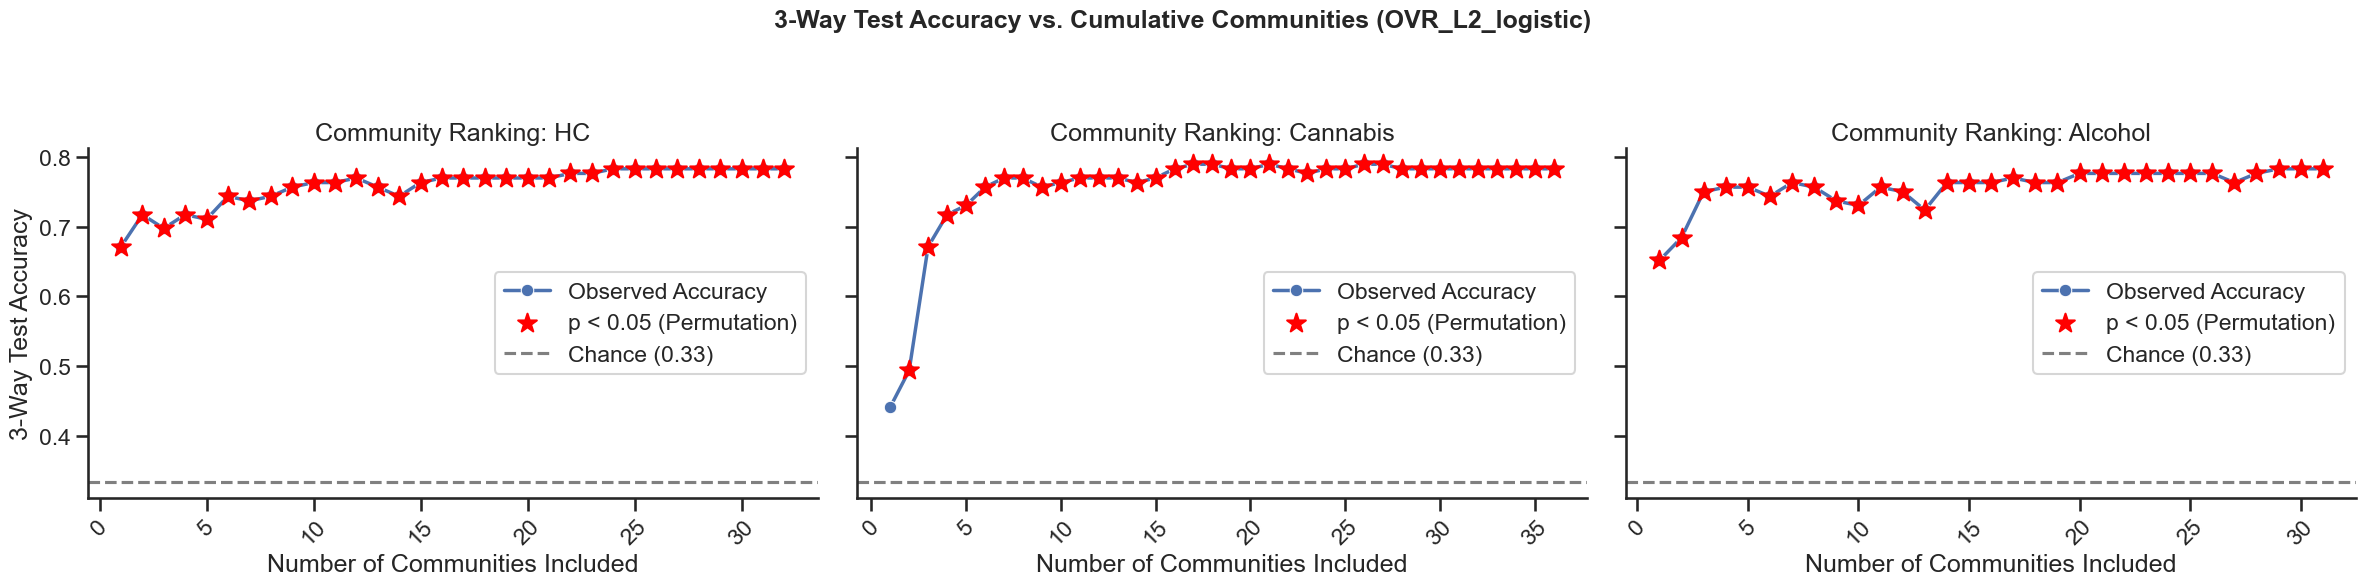


Finished Community 3-Way Classification Plotting



In [81]:
# === 4. Plot Cumulative Community 3-Way Accuracy Results ===
# This cell visualizes the 3-way test accuracy as communities are added.
# It creates one subplot per group whose community ranking was used for selection.
# It shows observed accuracy, chance level, and marks points where observed
# accuracy was significantly better than permuted accuracy (p < 0.05).

print("\n" + "="*40)
print("Plotting Cumulative Community 3-Way Classification Results")
print("="*40 + "\n")

if not all_community_results_3way:
    raise ValueError("Results dictionary 'all_community_results_3way' is empty. No data to plot.")

# --- Plotting Setup ---
sns.set_theme(style="ticks", context="talk") # Use a clean theme
groups_to_plot = ['HC', 'Cannabis', 'Alcohol'] # Define the groups for subplots
n_groups = len(groups_to_plot)

# Determine the base model key (assuming only one was analyzed in Cell 3, take the first)
# If multiple base models were run, you might need to adapt this or loop through them
if len(base_models_to_analyze) > 1:
     logging.warning(f"Multiple base models found ({base_models_to_analyze}). Plotting results only for the first one: '{base_models_to_analyze[0]}'")
plot_base_model_key = base_models_to_analyze[0]


# --- Create Figure with Subplots ---
fig, axes = plt.subplots(1, n_groups, figsize=(8 * n_groups, 6), sharey=True) # Share Y axis
fig.suptitle(f'3-Way Test Accuracy vs. Cumulative Communities ({plot_base_model_key})',
             fontsize=18, fontweight='bold', y=1.02) # Adjust title position

# Calculate chance level
chance_level_3way = 1.0 / len(np.unique(three_y_train))

# --- Loop through Groups to Create Subplots ---
plot_successful = False
for i, group_suffix in enumerate(groups_to_plot):
    ax = axes[i]
    analysis_key = f"{plot_base_model_key}_{group_suffix}"

    if analysis_key in all_community_results_3way:
        results_df = all_community_results_3way[analysis_key]
        plot_successful = True # Mark that at least one plot was generated

        # 1. Plot Observed Accuracy Line
        sns.lineplot(
            data=results_df,
            x='Num Communities',
            y='Test Accuracy (3-Way)',
            marker='o',
            ax=ax,
            label='Observed Accuracy',
            linewidth=2.5
        )

        # 2. Plot Significance Markers (if p-values exist and are valid)
        if 'Permutation P-Value (Test Acc)' in results_df.columns:
            significant_points = results_df[results_df['Permutation P-Value (Test Acc)'] < 0.05]
            if not significant_points.empty:
                ax.scatter(
                     x=significant_points['Num Communities'],
                     y=significant_points['Test Accuracy (3-Way)'],
                     marker='*',
                     s=200, # Size of the star marker
                     color='red', # Color for significance
                     label='p < 0.05 (Permutation)',
                     zorder=5 # Ensure markers are on top
                )
            else:
                # Add dummy scatter for consistent legend if no points are significant
                ax.scatter([], [], marker='*', color='red', label='p < 0.05 (Permutation)')
        else:
            logging.warning(f"Permutation p-value column not found for {analysis_key}. Significance markers skipped.")
            # Add dummy scatter for consistent legend
            ax.scatter([], [], marker='*', color='red', label='p < 0.05 (Permutation)')


        # 3. Plot Chance Level Line
        ax.axhline(chance_level_3way, ls='--', color='grey', label=f'Chance ({chance_level_3way:.2f})')

        # Subplot Formatting
        ax.set_title(f'Community Ranking: {group_suffix}')
        ax.set_xlabel('Number of Communities Included')
        ax.set_ylabel('3-Way Test Accuracy' if i == 0 else '') # Only label first y-axis
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        sns.despine(ax=ax)

    else:
        # Handle case where results for this group are missing
        ax.set_title(f'Community Ranking: {group_suffix}\n(No Results Found)')
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes, fontsize=14, color='grey')
        ax.set_xlabel('Number of Communities Included')
        ax.set_ylabel('3-Way Test Accuracy' if i == 0 else '')
        ax.set_yticks([]) # Remove y-ticks if no data
        sns.despine(ax=ax, left=True) # Remove y axis line too


plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout for main title

# --- Save the Combined Figure ---
if plot_successful:
    plot_path = COMMUNITY_CLASSIFIER_DIR / f"test_accuracy_3way_vs_communities_subplots_{plot_base_model_key}.svg"
    try:
        fig.savefig(plot_path, bbox_inches='tight')
        print(f"\nSaved combined plot: {plot_path}")
    except Exception as e:
        print(f"Error saving combined plot: {e}")
else:
    print("\nNo data was plotted successfully. Skipping figure save.")

plt.show() # Display the plot in the notebook

print("\n" + "="*40)
print("Finished Community 3-Way Classification Plotting")
print("="*40 + "\n")